<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Подготовка-фичей-и-таргета" data-toc-modified-id="Подготовка-фичей-и-таргета-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подготовка фичей и таргета</a></span><ul class="toc-item"><li><span><a href="#Без-BERT,-лемматизацией" data-toc-modified-id="Без-BERT,-лемматизацией-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Без BERT, лемматизацией</a></span></li><li><span><a href="#С-BERT,-Эмбеддингом" data-toc-modified-id="С-BERT,-Эмбеддингом-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>С BERT, Эмбеддингом</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Без-BERT" data-toc-modified-id="Без-BERT-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Без BERT</a></span></li><li><span><a href="#С-BERT" data-toc-modified-id="С-BERT-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>С BERT</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но мы можем попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!conda install pytorch torchvision torchaudio -c pytorch
!pip install -U transformers --user
!pip3 install -U lightgbm --user
!pip install -U catboost --user

In [26]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import transformers as megatron
from sklearn.model_selection import cross_val_score
from tqdm import notebook
import timeit

from timeit import default_timer as timer
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ivanovaleksandr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ivanovaleksandr/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None

Дублей: 0

Уникальных: text     159571
toxic         2
dtype: int64

Пустых: text     0
toxic    0
dtype: int64

                                                text  toxic
0  Explanation\nWhy the edits made under my usern...      0
1  D'aww! He matches this background colour I'm s...      0
2  Hey man, I'm really not trying to edit war. It...      0
3  "\nMore\nI can't make any real suggestions on ...      0
4  You, sir, are my hero. Any chance you remember...      0

                                                     text  toxic
121958  You are WRONG. \n\nJustin Thompson is mentione...      0
146867  "\n\n British Bands?  \n\nI think you've mista...      0
131932  I won't stop that. Sometimes Germanic equals G...      1
103694  Back it up. Post the line her

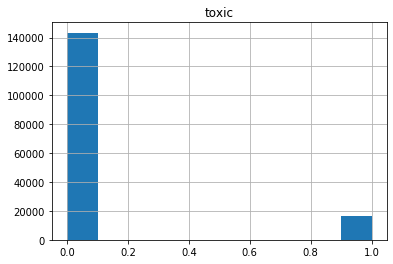

In [3]:
from io import BytesIO
import requests
spreadsheet_id = '1Pq1rtcpL06aaxrISF9mvVYx5ctUVWIdLKzqevPPtwPk'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))

#df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

def luk(data):
    print(data.info())
    print()
    print('Дублей:', data.duplicated().sum())
    print()
    print('Уникальных:', data.nunique())
    print()
    print('Пустых:', data.isna().sum())
    print()
    print(data.head())
    print()
    print(data.sample(n=10, replace=True, random_state=42))
    print()
    print(data.describe())
    print()
    df.hist()
    
luk(df)

Пустых строк нет. Виден дисбаланс значений таргета(учтем при обучении). В целом предоработка не требуется.

### Подготовка фичей и таргета

#### Без BERT, лемматизацией

In [4]:
#Создадим корпус и лематизируем его
#Сделаем через функции
#Для лемматизации используем инструменты WordNetLemmatizer
corpus = df['text']

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wn.ADJ,
                "N": wn.NOUN,
                "V": wn.VERB,
                "R": wn.ADV}
    return tag_dict.get(tag, wn.NOUN)

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    res = list()
    for word in words:
        p = lemmatizer.lemmatize(word, get_wordnet_pos(word))
        res.append(p)

    return ' '.join(res)

def clear_text(text):
    pattern = r'[^a-zA-Z]'
    new_text = re.sub(pattern, ' ', text).lower()
    return ' '.join(new_text.split())

In [5]:
#Лемматизируем, посмотрим на время
start_time = timer()
features = corpus.apply(lambda x: lemmatize(clear_text(x)))
lemmatizing_time = timer() - start_time
print("Время лемматизации: {:f} секунд".format(lemmatizing_time))

Время лемматизации: 840.277589 секунд


In [6]:
# Проверим результат работы
print(features.copy().loc[0])

explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now


In [10]:
#Подготовим фичи и таргет

target = df['toxic']
features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                              target,
                                                                              train_size=.75,
                                                                              random_state=42)

nltk.download('stopwords', quiet=True)
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

corpus_train = features_train.values.astype('U')
tf_idf_train = count_tf_idf.fit_transform(corpus_train)

corpus_valid = features_valid.values.astype('U') 
tf_idf_valid = count_tf_idf.transform(corpus_valid)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivanovaleksandr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### С BERT, Эмбеддингом

In [11]:
# DistilBERT (от HuggingFace), 
# очищенная версия BERT-а: меньше, быстрее, дешевле и легче
# создана Victor Sanh, Lysandre Debut и Thomas Wolf.
# https://huggingface.co/distilbert-base-uncased

model_class, tokenizer_class, pretrained_weights = (
    megatron.DistilBertModel, megatron.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
start_time = timer()
tokenized = df['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=df['text'].shape[0]))
tokenizing_time = timer() - start_time
print("Время токенизации: {:f} секунд".format(tokenizing_time))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Время токенизации: 212.311742 секунд


In [13]:
#Модель DistilBERT принимает максимальное количество токенов в тексте по умолчанию равное 512. 
#Посчитаем длины текстов с токенами:
len_sentences = [len(i) for i in tokenized]
len_sentences = pd.Series(len_sentences)
len_sentences.describe()

count    159571.000000
mean         94.891860
std         141.438775
min           4.000000
25%          26.000000
50%          52.000000
75%         104.000000
max        4950.000000
dtype: float64

Тут стоит отметить аномальнно длиные тексты

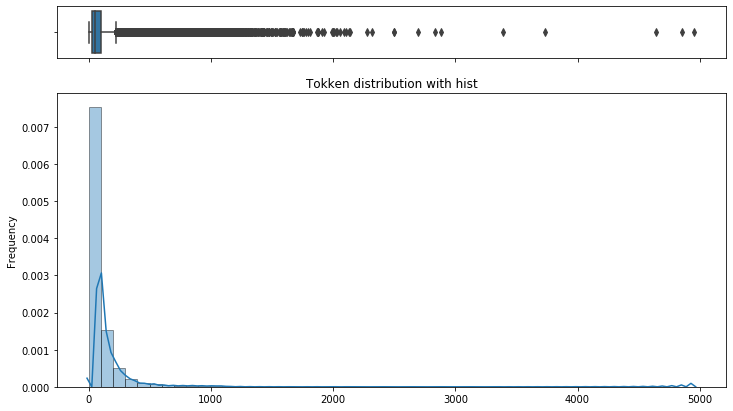

In [14]:
def plot_hist(data):

    f, (ax_box, ax_hist) = plt.subplots(2,
                                        sharex=True,
                                        gridspec_kw={'height_ratios': (.15, .85)},
                                        figsize=(12, 7))

    sns.distplot(data,
                 hist=True,
                 kde=True, 
                 bins=50,
                 hist_kws={'edgecolor':'black'})
    sns.boxplot(data,
                ax=ax_box)
    
    plt.ylabel('Frequency')
    plt.title('Tokken distribution with hist')
    
    plt.show()

plot_hist(len_sentences)

![](https://i.ytimg.com/vi/hoLiKI5lzkA/maxresdefault.jpg)

OH, my!!! Кому то нужно было выговориться, комментарием на 5000 знаков. Ограничим тексты максимальной длиной токенов 75% квантилем.

In [15]:
indexes = []
for i in notebook.tqdm(range(len(tokenized))):
    if len(tokenized[i]) <= len_sentences.quantile(.75):
        indexes.append(i)

filtered_df = df.query('index in @indexes')
filtered_df.shape

  0%|          | 0/159571 [00:00<?, ?it/s]

(119975, 2)

((26069, 2), (5000, 2))

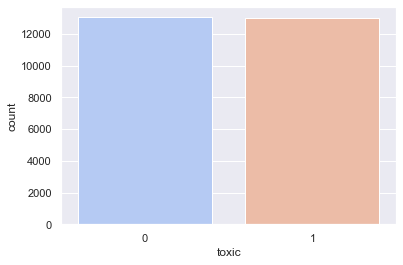

In [16]:
filtered_df_train, filtered_df_test = train_test_split(filtered_df, random_state=42, test_size=5000)
# Для того, чтобы сбалансировать метки целевого признака в обучающей выборке, 
# воспользуемся техникой downsampling

coef  = round((len(filtered_df_train[filtered_df_train['toxic'] == 1]) / 
               len(filtered_df_train[filtered_df_train['toxic'] == 0])), 3)

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=42)] +
                                     [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=42)] +
                                     [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,
                                                      random_state=42)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(filtered_df_train['text'], filtered_df_train['toxic'], coef)

sns.set()
sns.countplot(target_downsampled, palette='coolwarm');

features_downsampled = pd.DataFrame(features_downsampled).reset_index(drop=True)
target_downsampled = pd.DataFrame(target_downsampled).reset_index(drop=True)
filtered_df_train = features_downsampled.join(target_downsampled)
filtered_df_train.shape, filtered_df_test.shape

Эмбеддинги модель BERT создаёт батчами. Чтобы хватило оперативной памяти, сделаем размер батча небольшим (100). Обучающую выборку сделаем кратной размеру батча.

In [17]:
filtered_df_train = filtered_df_train[:26000]

start_time = timer()
tokenized_train = filtered_df_train['text'].apply(
    (lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=filtered_df_train['text'].shape[0])))
tokenizing_time = timer() - start_time
print("Время токенизации: {:f} секунд".format(tokenizing_time))

Время токенизации: 14.871446 секунд


In [18]:
start_time = timer()
tokenized_test = filtered_df_test['text'].apply(
    (lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=filtered_df_test['text'].shape[0])))
tokenizing_time = timer() - start_time
print("Время токенизации: {:f} секунд".format(tokenizing_time))

Время токенизации: 3.041263 секунд


In [19]:
# Применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными. 
# Только при таком условии будет работать модель BERT

def padding(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    return padded

padded_train = padding(tokenized_train)
padded_test = padding(tokenized_test)

# преобразуем маску
attention_mask_train = np.where(padded_train != 0, 1, 0)
attention_mask_test = np.where(padded_test != 0, 1, 0)
attention_mask_train.shape, attention_mask_test.shape

((26000, 104), (5000, 104))

Сделаем цикл по батчам. Отображать прогресс будет функция notebook()
Преобразуем данные в формат тензоров — многомерных векторов в библиотеке torch. Тип данных LongTensor хранит числа в «длинном формате», то есть выделяет на каждое число 64 бита.
Чтобы получить эмбеддинги для батча, передадим модели данные и маску
Для ускорения вычисления функцией no_grad() в библиотеке torch укажем, что градиенты не нужны: модель BERT обучать не будем.
Из полученного тензора извлечём нужные элементы batch_embeddings[0][:,0,:].numpy() и добавим в список всех эмбеддингов
Соберём все эмбеддинги в матрицу признаков вызовов функции concatenate():

In [20]:
def embedings(padded, attention_mask):
    batch_size = 100
    embeddings = []
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
            batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
            attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

            with torch.no_grad():
                batch_embeddings = model(batch, attention_mask=attention_mask_batch)

            embeddings.append(batch_embeddings[0][:,0,:].numpy())
    features = np.concatenate(embeddings)
    return features

In [21]:
# Подготовим фичи и таргет
features_train = embedings(padded_train, attention_mask_train)
features_test = embedings(padded_test, attention_mask_test)
labels_train = filtered_df_train['toxic']
labels_test = filtered_df_test['toxic']

  0%|          | 0/260 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

## Обучение

In [22]:
def model_search(model, params, features_t, features_v, target_t, target_v):
    
    #Обучение модели
    cv = ShuffleSplit(n_splits=2, test_size=0.25, random_state=42)
    grid = GridSearchCV(model,
                        params,
                        cv=cv,
                        scoring='f1',
                        n_jobs=-1)
    
    grid.fit(features_t, target_t)
    best_params = grid.best_params_
    prediction = grid.predict(features_v)
    
    #Classification Report
    f1 = round(f1_score(target_v, prediction), 3)
    precision = round(precision_score(target_v, prediction), 3)
    recall = round(recall_score(target_v, prediction), 3)
    roc_auc = round(roc_auc_score(target_v, prediction), 3)
    result_list = [f1, precision, recall, roc_auc]
    
    print('')
    print('Итоги обучения модели:')
    print('')
    print('- Лучшее сочетание гиперпараметров: \n  {}'.format(best_params))
    print('')
    print('- F1-мера модели: {}'.format(f1))
    print('')
    print('- Precision модели: {}'.format(precision))
    print('')
    print('- Recall модели: {}'.format(recall))
    print('')
    print('- ROC-AUC модели: {}'.format(roc_auc))
    print('')
    
    #ROC-AUC Curve Plot
    ns_probs = [0 for _ in range(len(target_v))]
    lr_probs = grid.predict_proba(features_v)
    lr_probs = lr_probs[:, 1]
    ns_fpr, ns_tpr, _ = roc_curve(target_v, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(target_v, lr_probs)
    
    f, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    ax[0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax[0].plot(lr_fpr, lr_tpr, marker='.', label='ROC-AUC={}'.format(roc_auc))
    ax[0].set_title('Receiver Operating Characteristic')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].legend()
    
    #Precision-Recall Curve Plot
    precision, recall, _ = precision_recall_curve(target_v, prediction)
    no_skill = len(target_v[target_v==1]) / len(target_v)
    
    ax[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    ax[1].plot(recall, precision, marker='.')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(['All Positive', 'Model'])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    
    plt.show()
    
    return result_list

### Без BERT


Итоги обучения модели:

- Лучшее сочетание гиперпараметров: 
  {'C': 25.000075, 'fit_intercept': True, 'tol': 0.0001}

- F1-мера модели: 0.762

- Precision модели: 0.719

- Recall модели: 0.81

- ROC-AUC модели: 0.887



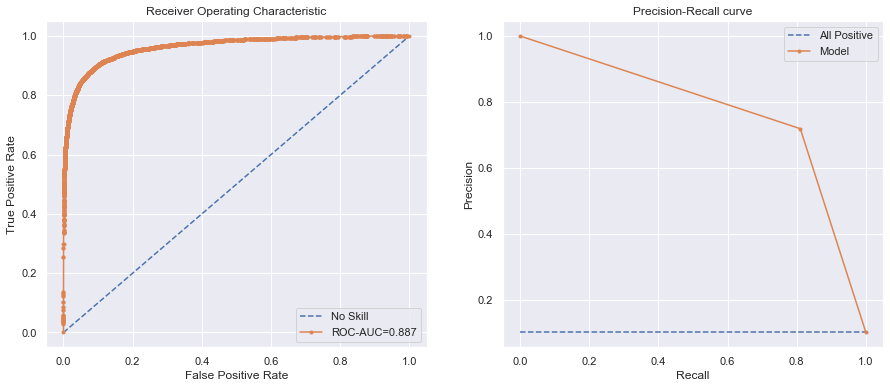

Время обучения модели: 32.475171 секунд


In [27]:
# Логистическая регрессия
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg_params = {'C' : np.linspace(1e-4, 100, 5),
                 'tol' : np.linspace(1e-4, 100, 5),
                 'fit_intercept' : [True, False]}

start_time = timer()
result_list_logreg = model_search(log_reg, log_reg_params, 
                                  tf_idf_train, tf_idf_valid, target_train, target_valid)
log_reg_time = timer() - start_time
print("Время обучения модели: {:f} секунд".format(log_reg_time))


Итоги обучения модели:

- Лучшее сочетание гиперпараметров: 
  {'learning_rate': 0.3, 'n_estimators': 500}

- F1-мера модели: 0.766

- Precision модели: 0.747

- Recall модели: 0.786

- ROC-AUC модели: 0.878



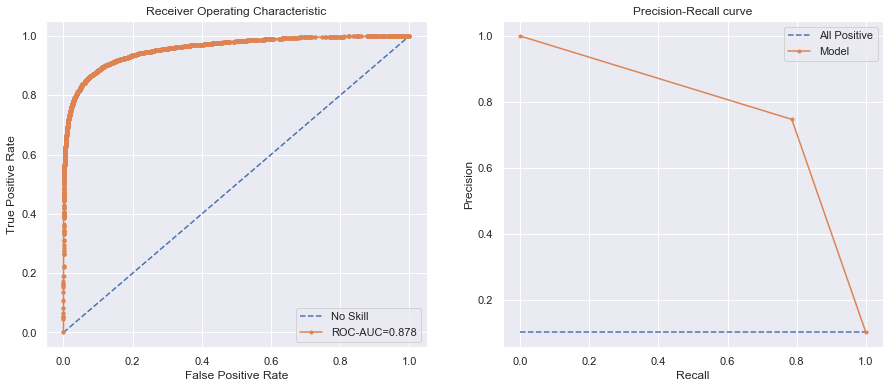

Время обучения модели: 448.317151 секунд


In [29]:
# lGBM

lgbm_clf = LGBMClassifier(n_jobs=-1, random_state=17, class_weight='balanced')
lgbm_clf_params = {'n_estimators': [500],
                   'learning_rate': [0.1, 0.3, 0.5]}

start_time = timer()
result_list_lgbm_clf = model_search(lgbm_clf, lgbm_clf_params, 
                                    tf_idf_train, tf_idf_valid, target_train, target_valid)
lgbm_clf_time = timer() - start_time
print("Время обучения модели: {:f} секунд".format(lgbm_clf_time))


Learning rate set to 0.150069
0:	learn: 0.6251777	total: 964ms	remaining: 8m 1s
1:	learn: 0.5854418	total: 1.74s	remaining: 7m 12s
2:	learn: 0.5596678	total: 2.69s	remaining: 7m 24s
3:	learn: 0.5421598	total: 3.74s	remaining: 7m 43s
4:	learn: 0.5314663	total: 4.61s	remaining: 7m 36s
5:	learn: 0.5211574	total: 5.47s	remaining: 7m 30s
6:	learn: 0.5105766	total: 6.26s	remaining: 7m 20s
7:	learn: 0.5038770	total: 7.03s	remaining: 7m 12s
8:	learn: 0.4964276	total: 7.75s	remaining: 7m 2s
9:	learn: 0.4906348	total: 8.22s	remaining: 6m 42s
10:	learn: 0.4854083	total: 8.89s	remaining: 6m 35s
11:	learn: 0.4764243	total: 9.4s	remaining: 6m 22s
12:	learn: 0.4708051	total: 9.97s	remaining: 6m 13s
13:	learn: 0.4656136	total: 10.5s	remaining: 6m 5s
14:	learn: 0.4615337	total: 11s	remaining: 5m 57s
15:	learn: 0.4572566	total: 11.6s	remaining: 5m 52s
16:	learn: 0.4534997	total: 12.1s	remaining: 5m 45s
17:	learn: 0.4499916	total: 12.9s	remaining: 5m 44s
18:	learn: 0.4474151	total: 13.6s	remaining: 5m 43

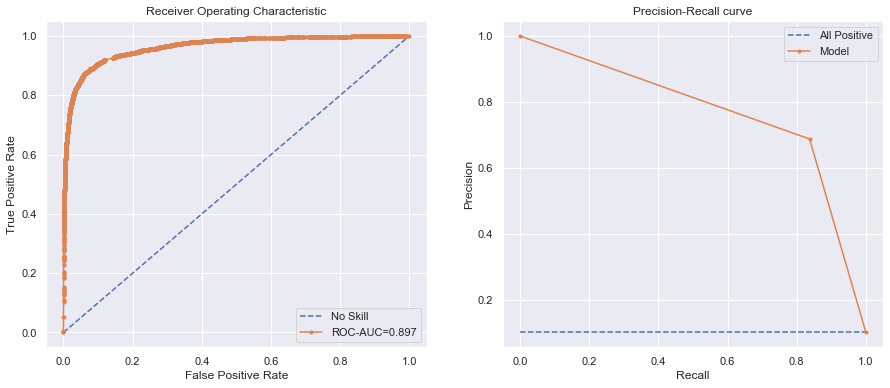

Время обучения модели: 905.599687 секунд


In [31]:
# Catboost
scale_pos_weight = round((len(target_train[target_train == 0]) / 
                          len(target_train[target_train == 1])), 3)

CatBoost_clf = CatBoostClassifier(random_state=42, iterations=500, scale_pos_weight=scale_pos_weight)
CatBoost_clf_params = {}
    
start_time = timer()
result_list_CatBoost_clf = model_search(CatBoost_clf, CatBoost_clf_params, 
                                    tf_idf_train, tf_idf_valid, target_train, target_valid)
CatBoost_clf_time = timer() - start_time
print("Время обучения модели: {:f} секунд".format(CatBoost_clf_time))


### С BERT


Итоги обучения модели:

- Лучшее сочетание гиперпараметров: 
  {'C': 25.000075, 'fit_intercept': True, 'tol': 0.0001}

- F1-мера модели: 0.682

- Precision модели: 0.546

- Recall модели: 0.908

- ROC-AUC модели: 0.907



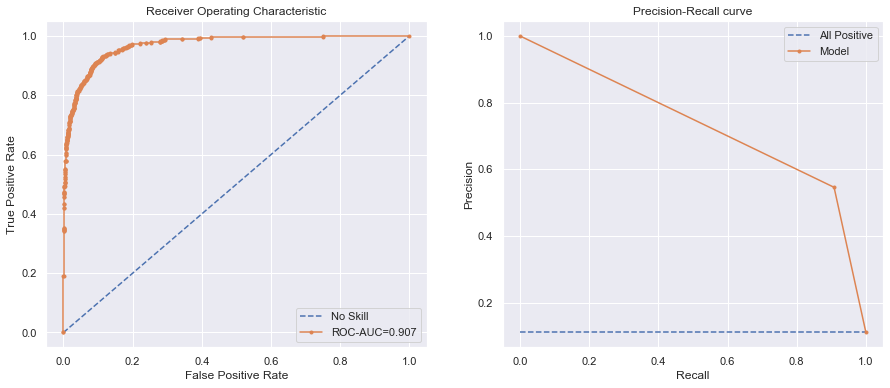

Время обучения модели: 100.402379 секунд


In [32]:
# Логистическая регрессия
log_reg_bert = LogisticRegression(random_state=42, class_weight='balanced')
params_logreg_bert = {'C' : np.linspace(1e-4, 100, 5),
                 'tol' : np.linspace(1e-4, 100, 5),
                 'fit_intercept' : [True, False]}

start_time = timer()
result_list_logreg_bert = model_search(log_reg_bert, params_logreg_bert, 
                                  features_train, features_test, labels_train, labels_test)
logn_reg_time_bert = timer() - start_time
print("Время обучения модели: {:f} секунд".format(logn_reg_time_bert))



Итоги обучения модели:

- Лучшее сочетание гиперпараметров: 
  {'learning_rate': 0.1, 'n_estimators': 500}

- F1-мера модели: 0.663

- Precision модели: 0.526

- Recall модели: 0.897

- ROC-AUC модели: 0.898



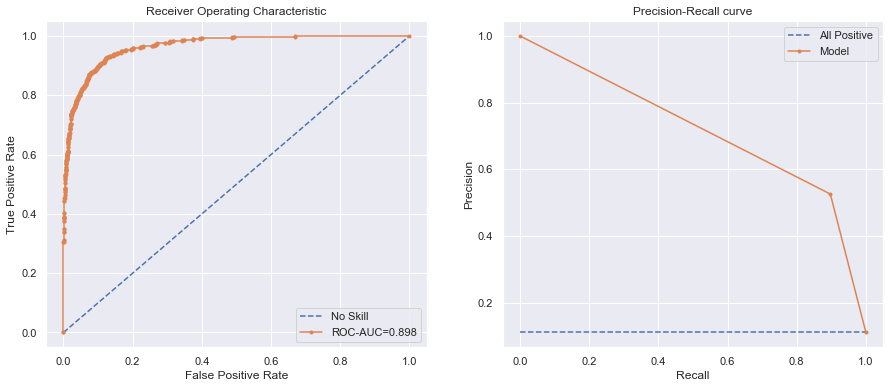

Время обучения модели: 159.897042 секунд


In [33]:
# lGBM

lgbm_clf_bert = LGBMClassifier(n_jobs=-1, random_state=17, class_weight='balanced')
lgbm_clf_params_bert = {'n_estimators': [500],
                   'learning_rate': [0.1, 0.3, 0.5]}

start_time = timer()
result_list_lgbm_clf_bert = model_search(lgbm_clf_bert, lgbm_clf_params_bert, 
                                    features_train, features_test, labels_train, labels_test)
lgbm_clf_time_bert = timer() - start_time
print("Время обучения модели: {:f} секунд".format(lgbm_clf_time_bert))


Learning rate set to 0.078194
0:	learn: 0.6386320	total: 76.2ms	remaining: 38s
1:	learn: 0.5964405	total: 125ms	remaining: 31.2s
2:	learn: 0.5589349	total: 170ms	remaining: 28.2s
3:	learn: 0.5269635	total: 217ms	remaining: 26.9s
4:	learn: 0.5017397	total: 262ms	remaining: 26s
5:	learn: 0.4784756	total: 309ms	remaining: 25.5s
6:	learn: 0.4584575	total: 355ms	remaining: 25s
7:	learn: 0.4415092	total: 402ms	remaining: 24.7s
8:	learn: 0.4258077	total: 454ms	remaining: 24.8s
9:	learn: 0.4125843	total: 502ms	remaining: 24.6s
10:	learn: 0.4014022	total: 549ms	remaining: 24.4s
11:	learn: 0.3917192	total: 598ms	remaining: 24.3s
12:	learn: 0.3827559	total: 645ms	remaining: 24.2s
13:	learn: 0.3748584	total: 693ms	remaining: 24.1s
14:	learn: 0.3684344	total: 739ms	remaining: 23.9s
15:	learn: 0.3621201	total: 785ms	remaining: 23.7s
16:	learn: 0.3563534	total: 831ms	remaining: 23.6s
17:	learn: 0.3505931	total: 877ms	remaining: 23.5s
18:	learn: 0.3464276	total: 925ms	remaining: 23.4s
19:	learn: 0.340

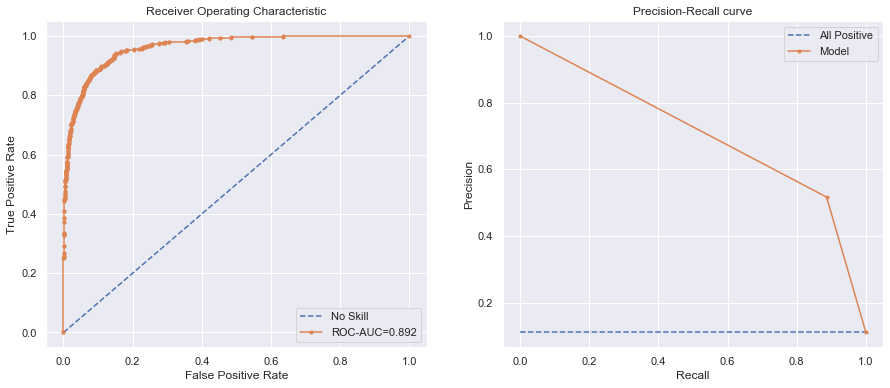

Время обучения модели: 69.982871 секунд


In [34]:
# Catboost

CatBoost_clf_bert = CatBoostClassifier(random_state=42, iterations=500)
CatBoost_clf_params_bert = {}
    
start_time = timer()
result_list_CatBoost_clf_bert = model_search(CatBoost_clf_bert, CatBoost_clf_params_bert, 
                                    features_train, features_test, labels_train, labels_test)
CatBoost_clf_time_bert = timer() - start_time
print("Время обучения модели: {:f} секунд".format(CatBoost_clf_time_bert))


## Выводы

In [ ]:
result_list_logreg.append(log_reg_time),
result_list_lgbm_clf.append(lgbm_clf_time),
result_list_CatBoost_clf.append(CatBoost_clf_time),
result_list_logreg_bert.append(lgbm_clf_time_bert),
result_list_lgbm_clf_bert.append(lgbm_clf_time_bert),
result_list_CatBoost_clf_bert.append(CatBoost_clf_time_bert)}

In [94]:
dict = {'LogisticRegression' : result_list_logreg,
        'LGBMClassifier' : result_list_lgbm_clf,
        'CatBoostClassifier' : result_list_CatBoost_clf,
        'LogisticRegression_bert' : result_list_logreg_bert,
        'LGBMClassifier_bert' : result_list_lgbm_clf_bert,
        'CatBoostClassifier_bert' : result_list_CatBoost_clf_bert}

In [96]:
result_tab = pd.DataFrame.from_dict(dict,
                                    orient='index',
                                    columns=['F1-score', 'Precision', 'Recall', 'ROC-AUC', 'Time']).sort_values(by='F1-score',
                                                                                                        ascending=False)
result_tab

,F1-score,Precision,Recall,ROC-AUC,Time
LGBMClassifier,0.766,0.747,0.786,0.878,448.317151
LogisticRegression,0.762,0.719,0.810,0.887,32.475171
CatBoostClassifier,0.755,0.688,0.837,0.897,905.599687
LogisticRegression_bert,0.682,0.546,0.908,0.907,159.897042
LGBMClassifier_bert,0.663,0.526,0.897,0.898,159.897042
CatBoostClassifier_bert,0.653,0.517,0.886,0.892,69.982871


> По результатам исследований моделей для поставленной задачи наиболее оптимальными являются:
- **LogisticRegression**  

>**LogisticRegression** -  базовая модель, показывает хорошие показатели метрик и скорости обучения и предсказания, очень проста в настройке и не требует особой настройки гиперпараметров по сетке. Очень хорошо работает с предобработанными данными, т.е. после TF-IDF.     
В целом все модели дают хорошие показатели метрики, но по скорости обучения отличаются.

> Представление текста в векторную форму через BERT, в данном случае не оправдано, т.к. эмбединг занимает времени больше чем лемматизация, а показатель метрики падает.

>Для данной задачи лучшая для заказчика в плане качества предсказания, скорости предсказания, время обучения - **LogisticRegression**.     
Т.к. лучше всего работает с предобработанными данными и имеет самую высокую скорость обучения.